Standard Deviation of Ratio Map: 1.5767563883738265
Standard Deviation of area_above_continuum_map: 0.001984501483846634


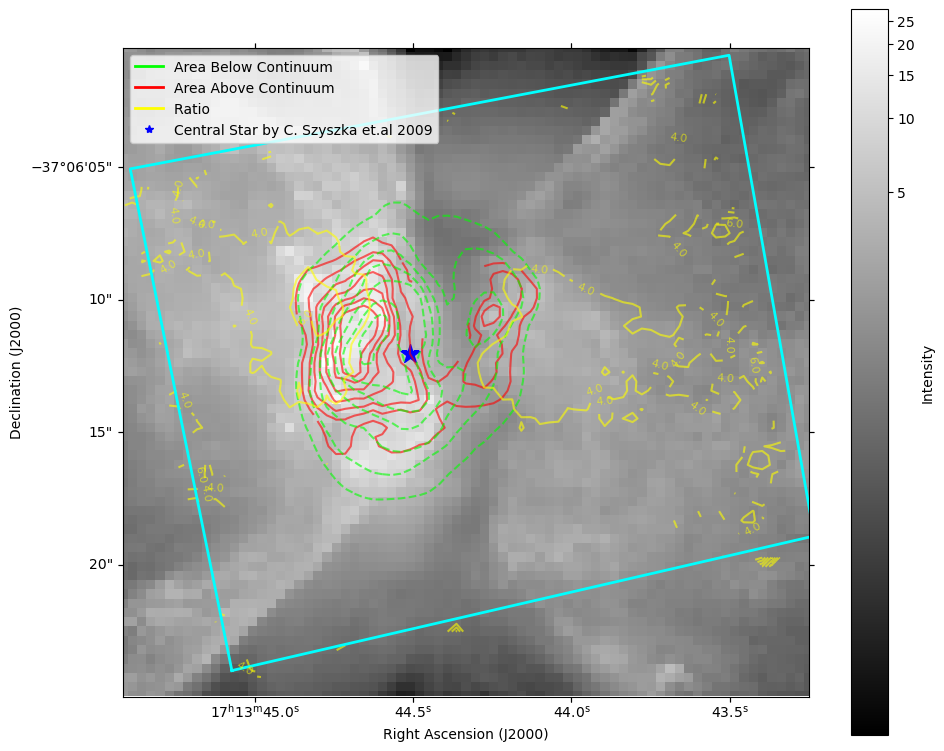

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpdaf.obj import Cube
import astropy.units as u
import warnings
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS, FITSFixedWarning
from astropy.io import fits
from reproject import reproject_interp
from astropy.visualization import (MinMaxInterval, LogStretch, ImageNormalize)

# Ignore warnings
warnings.filterwarnings('ignore', category=FITSFixedWarning)
warnings.filterwarnings('ignore', category=UserWarning, message="Warning: converting a masked element to nan.")

optical_image_path = '/Users/mary/Downloads/F658N2009_tweak2F110W_drc_Gaia.fits'
optical_image_data, optical_image_header = fits.getdata(optical_image_path, header=True)
optical_wcs = WCS(optical_image_header)

cube_path = '/Users/mary/Fits image of JWST/ngc6302_ch4-short_s3d.fits'
obj1 = Cube(cube_path)

cube_header = fits.getheader(cube_path, ext=1) 
cube_wcs = WCS(cube_header).celestial 

area_above_continuum_map = np.loadtxt('19.56area_above_continuum.txt')
area_below_continuum_map = np.loadtxt('19.56area_below_continuum.txt')
ratio_map = np.loadtxt('19.56ratio_map.txt')

# RA and Dec coordinates of the central star
ra_deg = 258.4353666666666
dec_deg = -37.10326666666667
skycoord = SkyCoord(ra=ra_deg*u.degree, dec=dec_deg*u.degree, frame='icrs')

# Reproject the HST Fits image 
reprojected_image, footprint = reproject_interp(
    (optical_image_data, optical_wcs), cube_wcs, shape_out=obj1.shape[1:]
)

if reprojected_image is None or reprojected_image.size == 0:
    raise ValueError("Reprojected image not loaded correctly.")

optical_pixel_coords = cube_wcs.world_to_pixel(skycoord)
optical_pixel_x, optical_pixel_y = int(optical_pixel_coords[0]), int(optical_pixel_coords[1])

norm = ImageNormalize(reprojected_image, interval=MinMaxInterval(), stretch=LogStretch())
plt.figure(figsize=(10, 8))
ax = plt.subplot(projection=cube_wcs)
ax.set_xlim(0, 74)  
ax.set_ylim(0, 70)  
im = ax.imshow(reprojected_image, cmap='gray', origin='lower', aspect='equal', norm=norm)
plt.colorbar(im, ax=ax, label='Intensity')

# Calculate standard deviation for the ratio and area above continuum line
std_ratio_map = np.nanstd(ratio_map)
print(f"Standard Deviation of Ratio Map: {std_ratio_map}")

std_area_above_continuum_map = np.nanstd(area_above_continuum_map)
print(f"Standard Deviation of area_above_continuum_map: {std_area_above_continuum_map}")

higher_threshold = std_ratio_map *2
filtered_ratio_map = np.where(np.isfinite(ratio_map) & (ratio_map > higher_threshold), ratio_map, np.nan)
filtered_area_above_continuum_map = np.where(area_above_continuum_map > std_area_above_continuum_map, area_above_continuum_map, np.nan)

contour1 = ax.contour(filtered_area_above_continuum_map, colors='red', alpha=0.6, transform=ax.get_transform(cube_wcs))
contour2 = ax.contour(area_below_continuum_map, colors='lime', linestyles='--', alpha=0.6, transform=ax.get_transform(cube_wcs))
contour3 = ax.contour(filtered_ratio_map, colors='yellow', alpha=0.6, transform=ax.get_transform(cube_wcs))
ax.clabel(contour3, inline=True, fontsize=8, fmt='%1.1f')

# points for the magenta box base on data cube edge pixels
specific_points = [
    (11.7641, 2.79749),
    (0.795407, 56.9403),
    (65.4217, 69.2025),
    (74.6117, 17.3236)
]
for x, y in specific_points:
    ax.scatter(x, y, color='red', s=50, marker='none', transform=ax.get_transform(cube_wcs))
    
specific_points.append(specific_points[0])
x_coords, y_coords = zip(*specific_points)
ax.plot(x_coords, y_coords, color='cyan', linestyle='-', linewidth=2, transform=ax.get_transform(cube_wcs))
plt.scatter(optical_pixel_x, optical_pixel_y, color='blue', marker='*', s=200, label='Central Star by C. Szyszka et.al 2009')
red_patch = plt.Line2D([0], [0], color='lime', lw=2, label='Area Below Continuum')
blue_patch = plt.Line2D([0], [0], color='red', lw=2, label='Area Above Continuum')
green_patch = plt.Line2D([0], [0], color='yellow', lw=2, label='Ratio ')
plt.legend(handles=[red_patch, blue_patch, green_patch, plt.Line2D([0], [0], color='blue', marker='*', lw=0, label='Central Star by C. Szyszka et.al 2009')], loc='upper left')
ax.set_xlabel('Right Ascension (J2000)')
ax.set_ylabel('Declination (J2000)') 
ax.coords['ra'].set_ticklabel_position('b')
ax.coords['dec'].set_ticklabel_position('l')
plt.tight_layout()
plt.title('')
plt.savefig('ratio on HST image for 19.56.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()